*   Nama : **Virgiawan Teguh Kusuma**
*   Email : **181240000833@unisnu.ac.id**
*   Domisili : **Kabupaten Jepara, Jawa Tengah**

In [2]:
# import library 
import zipfile, os
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import files
import matplotlib.image as mpimg

In [3]:
# load google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# extract file masker.zip
maskerZip = '/content/drive/MyDrive/masker.zip'
maskerZipRef = zipfile.ZipFile(maskerZip, 'r')
maskerZipRef.extractall('/content')
maskerZipRef.close()

In [5]:
# list directory
os.listdir('/content/Face Mask Dataset')

['Test', 'Train', 'Validation']

In [33]:
# inisialisasi path test, train, validation dll
testPath = '/content/Face Mask Dataset/Test'
trainPath = '/content/Face Mask Dataset/Train'
valPath = '/content/Face Mask Dataset/Validation'

In [34]:
# augmentasi gambar dengan ImageDataGenerator
trainDataGenerator = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode= 'nearest'
    )

testDataGenerator = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode= 'nearest'
    )

In [35]:
trainGenerator = trainDataGenerator.flow_from_directory(
    directory=trainPath,
    target_size=(64,64),
    batch_size=32,
    subset='training',
    class_mode='categorical'
    )

valGenerator = testDataGenerator.flow_from_directory(
    directory=valPath,
    target_size=(64,64),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
    )

Found 8000 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
print(trainGenerator.class_indices)

{'WithMask': 0, 'WithoutMask': 1}


In [21]:
# model sequential
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [22]:
# menggunakan callback agar pengujian berhenti jika mae mencapai target
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [23]:
# compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(), 
              metrics=['accuracy']
              )

In [24]:
# train model dengan fit
history = model.fit(trainGenerator,
                    steps_per_epoch=len(trainGenerator)//32,
                    epochs=20, 
                    validation_data=valGenerator,
                    callbacks=[callback]
                    )

Epoch 1/20
7/7 [==============================] - 4s 431ms/step - loss: 0.7890 - accuracy: 0.5045 - val_loss: 0.6411 - val_accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 3s 396ms/step - loss: 0.5657 - accuracy: 0.6875 - val_loss: 0.4417 - val_accuracy: 0.9062
Epoch 3/20
7/7 [==============================] - 3s 397ms/step - loss: 0.3548 - accuracy: 0.9107 - val_loss: 0.4065 - val_accuracy: 0.8313
Epoch 4/20
7/7 [==============================] - 3s 397ms/step - loss: 0.3409 - accuracy: 0.8795 - val_loss: 0.2960 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 3s 397ms/step - loss: 0.2910 - accuracy: 0.8884 - val_loss: 0.2295 - val_accuracy: 0.9250
Epoch 6/20
7/7 [==============================] - 3s 390ms/step - loss: 0.3084 - accuracy: 0.8661 - val_loss: 0.2227 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 3s 391ms/step - loss: 0.2153 - accuracy: 0.9420 - val_loss: 0.3149 - val_accuracy: 0.8875
Epoch 8/20
7/7 [====

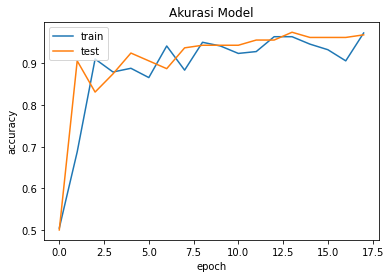

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

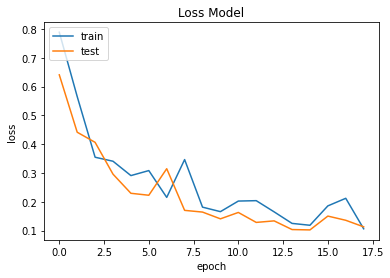

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Saving 1566097921.png to 1566097921.png
1566097921.png
[1]
Tidak Pakai Masker


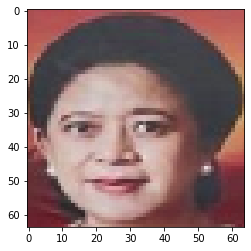

In [31]:
# memprediksi gambar
%matplotlib inline

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(64, 64))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  predIdxs = np.argmax(classes, axis=1)
  
  print(fn)
  print(predIdxs)
  if classes[0, 0] != 0:
    print('Pakai Masker')
  else:
    print('Tidak Pakai Masker')

In [ ]:
# konversi model TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps8w8nz5w/assets


INFO:tensorflow:Assets written to: /tmp/tmps8w8nz5w/assets


In [ ]:
# simpan model dengan format .tflite
with tf.io.gfile.GFile('masker.tflite', 'wb') as f:
  f.write(tflite_model)